<a href="https://colab.research.google.com/github/thomasshin/NLP_Study/blob/main/Pytorch_Practices/Pytorch_Practice4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Neural Network Classification with PyTorch

Data

In [1]:
import sklearn
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch import nn

In [2]:
from sklearn.datasets import make_circles

n_samples = 1000
X, y = make_circles(n_samples, noise=0.03, random_state=42)

In [3]:
X[:5], y[:5]

(array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343]]),
 array([1, 1, 1, 1, 0]))

In [4]:
df = pd.DataFrame({'X' : X[:, 0],
                   'y' : X[:, 1],
                   'label' : y})
df.head()

,X,y,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


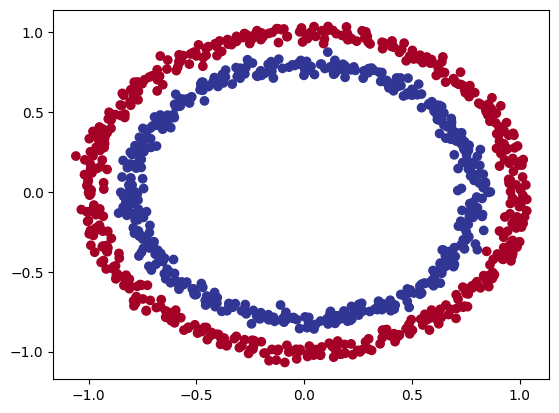

In [5]:
plt.scatter(df.X, df.y, c=df.label, cmap=plt.cm.RdYlBu)

Let's find out how we could build a PyTorch neural network to classify dots into red (0) or blue (1).

#Turn data into tensors

In [6]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [7]:
X[:10].dtype, y[:10].dtype

(torch.float32, torch.float32)

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [9]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

#Building a model

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [11]:
class circlemodel(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(in_features=2, out_features=6)
    self.layer2 = nn.Linear(in_features=6, out_features=1)
    #self.seq = nn.Sequential(
      #nn.Linear(in_features=2, out_features=6),
      #nn.Linear(in_features=6, out_features=1)
    #)
  def forward(self,x):
    return self.layer2(self.layer1(x))
    #return self.seq
#create an instance of the model and set to gpu
model1 = circlemodel().to(device)
model1

circlemodel(
  (layer1): Linear(in_features=2, out_features=6, bias=True)
  (layer2): Linear(in_features=6, out_features=1, bias=True)
)

The only major change is what's happening between self.layer_1 and self.layer_2.

self.layer_1 takes 2 input features in_features=2 and produces 5 output features out_features=5.

This is known as having 5 hidden units or neurons.

This layer turns the input data from having 2 features to 5 features.

Why do this?

This allows the model to learn patterns from 5 numbers rather than just 2 numbers, potentially leading to better outputs.

I say potentially because sometimes it doesn't work.

The number of hidden units you can use in neural network layers is a hyperparameter (a value you can set yourself) and there's no set in stone value you have to use.

Generally more is better but there's also such a thing as too much. The amount you choose will depend on your model type and dataset you're working with.

#nn.Sequential

In [12]:
model2 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model2

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

Woah, that looks much simpler than subclassing nn.Module, why not just always use nn.Sequential?

nn.Sequential is fantastic for straight-forward computations, however, as the namespace says, it always runs in sequential order.

So if you'd something else to happen (rather than just straight-forward sequential computation) you'll want to define your own custom nn.Module subclass.

Now we've got a model, let's see what happens when we pass some data through it.

In [13]:
#Make the prediction with the model first
with torch.inference_mode():
  pred1 = model1(X_test.to(device))
pred1[:10], y_test[:10]

(tensor([[-0.1339],
         [-0.0134],
         [-0.3163],
         [-0.3993],
         [-0.0218],
         [-0.0270],
         [-0.3988],
         [ 0.0419],
         [-0.1818],
         [ 0.0442]], device='cuda:0'),
 tensor([0., 1., 0., 0., 1., 0., 0., 0., 0., 0.]))

#Set up loss function and optimizer

But different problem types require different loss functions.

For example, for a regression problem (predicting a number) you might used mean absolute error (MAE) loss.

And for a binary classification problem (like ours), you'll often use binary cross entropy as the loss function.

However, the same optimizer function can often be used across different problem spaces.

For example, the stochastic gradient descent optimizer (SGD, torch.optim.SGD()) can be used for a range of problems, and the same applies to the Adam optimizer (torch.optim.Adam()).

PyTorch has two binary cross entropy implementations:

torch.nn.BCELoss() - Creates a loss function that measures the binary cross entropy between the target (label) and input (features).
torch.nn.BCEWithLogitsLoss() - This is the same as above except it has a sigmoid layer (nn.Sigmoid) built-in (we'll see what this means soon).
Which one should you use?

The documentation for torch.nn.BCEWithLogitsLoss() states that it's more numerically stable than using torch.nn.BCELoss() after a nn.Sigmoid layer.

So generally, implementation 2 is a better option. However for advanced usage, you may want to separate the combination of nn.Sigmoid and torch.nn.BCELoss() but that is beyond the scope of this notebook.

Knowing this, let's create a loss function and an optimizer.

For the optimizer we'll use torch.optim.SGD() to optimize the model parameters with learning rate 0.1.

In [14]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model1.parameters(),lr=0.1)

In [15]:
def accuracy_func(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item() #number of correct
  acc = (correct / len(y_pred)) * 100
  return acc

In [16]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

#Train model

**Forward pass** - The model goes through all of the training data once, performing its  forward() function calculations (model(x_train)).

**Calculate the loss** - The model's outputs (predictions) are compared to the ground truth and evaluated to see how wrong they are (loss = loss_fn(y_pred, y_train).

**Zero gradients** - The optimizers gradients are set to zero (they are accumulated by default) so they can be recalculated for the specific training step (optimizer.zero_grad()).

**Perform backpropagation on the loss** - Computes the gradient of the loss with respect for every model parameter to be updated (each parameter with requires_grad=True). This is known as backpropagation, hence "backwards" (loss.backward()).

**Step the optimizer (gradient descent)** - Update the parameters with requires_grad=True with respect to the loss gradients in order to improve them (optimizer.step()).

#Going from raw model outputs to predicted labels
###(logits -> prediction probabilities -> prediction labels)

Before the training loop steps, let's see what comes out of our model during the forward pass (the forward pass is defined by the forward() method).

In [17]:
y_logit = model1(X_test.to(device))
y_logit[:5]

tensor([[-0.1339],
        [-0.0134],
        [-0.3163],
        [-0.3993],
        [-0.0218]], device='cuda:0', grad_fn=<SliceBackward0>)

In [18]:
y_sigmoid = torch.sigmoid(y_logit)
y_sigmoid[:5]

tensor([[0.4666],
        [0.4967],
        [0.4216],
        [0.4015],
        [0.4945]], device='cuda:0', grad_fn=<SliceBackward0>)

In [19]:
y_label = torch.round(y_sigmoid)
y_label[:5]

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0', grad_fn=<SliceBackward0>)

In [20]:
#all at once (logit -> prob (torch.sigmoid) -> label (torch.round))
y_labelss = torch.round(torch.sigmoid(model1(X_test.to(device))))
y_labelss[:5]

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0', grad_fn=<SliceBackward0>)

In [21]:
#check for equality
print(torch.eq(y_label.squeeze(), y_labelss.squeeze()))
y_labelss.squeeze()

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, Tr

tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
        1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0.,
        0., 0.], device='cuda:0', grad_fn=<SqueezeBackward0>)

#Training and Testing Loop



In [22]:
y_train.shape

torch.Size([800])

In [23]:
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

In [24]:
torch.manual_seed(42)
epochs = 1000

for epoch in range(epochs):
  #training mode
  model1.train()
  #initial model output = logits
  train_y_logits = model1(X_train).squeeze()
  #convert it to pred probs
  y_prob = torch.sigmoid(train_y_logits)
  #convert it to 0,1
  train_y_label = torch.round(torch.sigmoid(train_y_logits))
  #train loss
  train_loss = loss_fn(train_y_logits, y_train) #because the loss function is nn.BCEWithLogitsLoss()
  #train accuracy
  train_acc = accuracy_func(y_train, train_y_label)
  #optimizer zero grad
  optimizer.zero_grad()
  #backprop
  train_loss.backward()
  #optimizer step
  optimizer.step()

  #test mode
  model1.eval()
  with torch.inference_mode():
    #test loss
    test_y_logits = model1(X_test).squeeze()
    test_y_label = torch.round(torch.sigmoid(test_y_logits))
    test_loss = loss_fn(test_y_logits, y_test)
    test_acc = accuracy_func(y_test, test_y_label)

  if epoch % 100 == 0:
    print(f"epoch : {epoch} | train loss : {train_loss} | train accuracy : {train_acc} | test loss : {test_loss} | test accuracy {test_acc}")

epoch : 0 | train loss : 0.6993187665939331 | train accuracy : 45.125 | test loss : 0.7025285959243774 | test accuracy 43.5
epoch : 100 | train loss : 0.6933226585388184 | train accuracy : 49.5 | test loss : 0.6958075761795044 | test accuracy 43.5
epoch : 200 | train loss : 0.6926665306091309 | train accuracy : 49.125 | test loss : 0.6970869302749634 | test accuracy 41.5
epoch : 300 | train loss : 0.6925472617149353 | train accuracy : 49.375 | test loss : 0.6979356408119202 | test accuracy 43.0
epoch : 400 | train loss : 0.692525327205658 | train accuracy : 49.875 | test loss : 0.698372483253479 | test accuracy 43.0
epoch : 500 | train loss : 0.6925212144851685 | train accuracy : 50.125 | test loss : 0.6985787153244019 | test accuracy 43.5
epoch : 600 | train loss : 0.6925204396247864 | train accuracy : 50.125 | test loss : 0.6986724138259888 | test accuracy 43.5
epoch : 700 | train loss : 0.692520260810852 | train accuracy : 50.125 | test loss : 0.6987141370773315 | test accuracy 44.0

#Make a prediction and evaluate the model

In [25]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

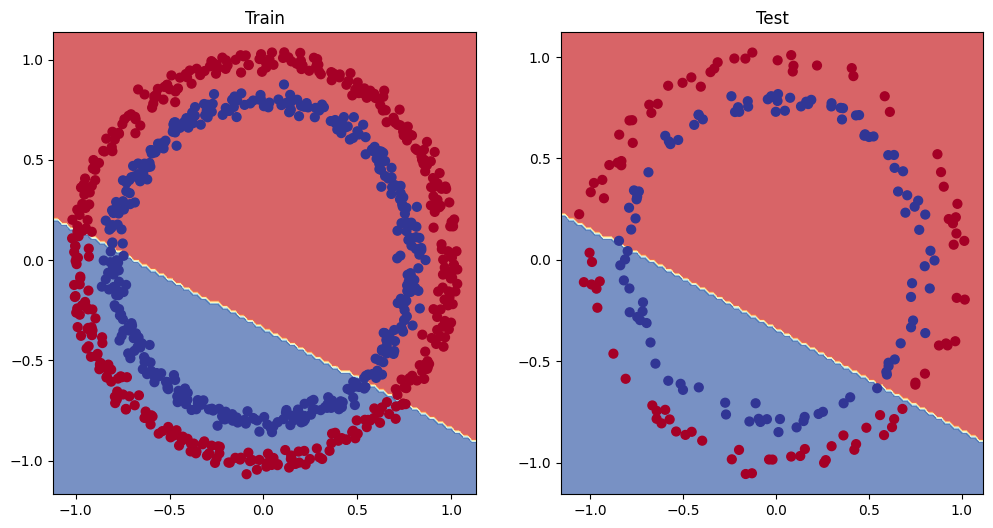

In [26]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model1, X_test, y_test)

#Improving a model

1. Add more layers
2. Add more hidden units
3. Fitting for longer (more epochs)
4. Changing the activation functions
5. Change the learning rate
6. Change the loss function
7. Use transfer learning

- These are called Hyperparameter, because we can adjust them by hand

In [27]:
class circlemodel2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(in_features=2, out_features=10)
    self.layer2 = nn.Linear(in_features=10, out_features=10)
    self.layer3 = nn.Linear(in_features=10, out_features=1)

  def forward(self, x):
    return self.layer3(self.layer2(self.layer1(x)))

model2 = circlemodel2().to(device)
model2

circlemodel2(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
)

In [28]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model2.parameters(), lr = 0.01)

In [29]:
X_train.shape

torch.Size([800, 2])

In [30]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
epochs = 1000

for epoch in range(1, epochs+1):
  #train mode
  model2.train()
  train_logitss = model2(X_train).squeeze()
  train_labelss = torch.round(torch.sigmoid(train_logitss))
  #train_loss
  train_losss = loss_fn(train_logitss, y_train)
  train_accc = accuracy_func(y_train, train_labelss)
  #optim zero grad
  optimizer.zero_grad()
  #backprop
  train_losss.backward()
  #optimizer step
  optimizer.step()

  #test mode
  model2.eval()
  with torch.inference_mode():
    test_logitss = model2(X_test).squeeze()
    test_labelss = torch.round(torch.sigmoid(test_logitss))
    test_losss = loss_fn(test_logitss, y_test)
    test_accc = accuracy_func(y_test, test_labelss)

  if epoch % 100 == 0:
    print(f"epoch : {epoch} | train_loss : {train_losss} | train_accuracy : {train_accc} | test_loss : {test_losss} | test_accuracy : {test_accc}")

epoch : 100 | train_loss : 0.693018913269043 | train_accuracy : 51.0 | test_loss : 0.6957184672355652 | test_accuracy : 47.0
epoch : 200 | train_loss : 0.6928641200065613 | train_accuracy : 50.5 | test_loss : 0.6962371468544006 | test_accuracy : 45.0
epoch : 300 | train_loss : 0.6927760243415833 | train_accuracy : 50.24999999999999 | test_loss : 0.6965963840484619 | test_accuracy : 45.0
epoch : 400 | train_loss : 0.6927164793014526 | train_accuracy : 49.625 | test_loss : 0.6968571543693542 | test_accuracy : 45.0
epoch : 500 | train_loss : 0.6926727294921875 | train_accuracy : 49.25 | test_loss : 0.6970596313476562 | test_accuracy : 45.5
epoch : 600 | train_loss : 0.6926392912864685 | train_accuracy : 48.625 | test_loss : 0.6972267031669617 | test_accuracy : 46.0
epoch : 700 | train_loss : 0.6926134824752808 | train_accuracy : 48.125 | test_loss : 0.6973709464073181 | test_accuracy : 46.0
epoch : 800 | train_loss : 0.6925933957099915 | train_accuracy : 48.875 | test_loss : 0.69749921560

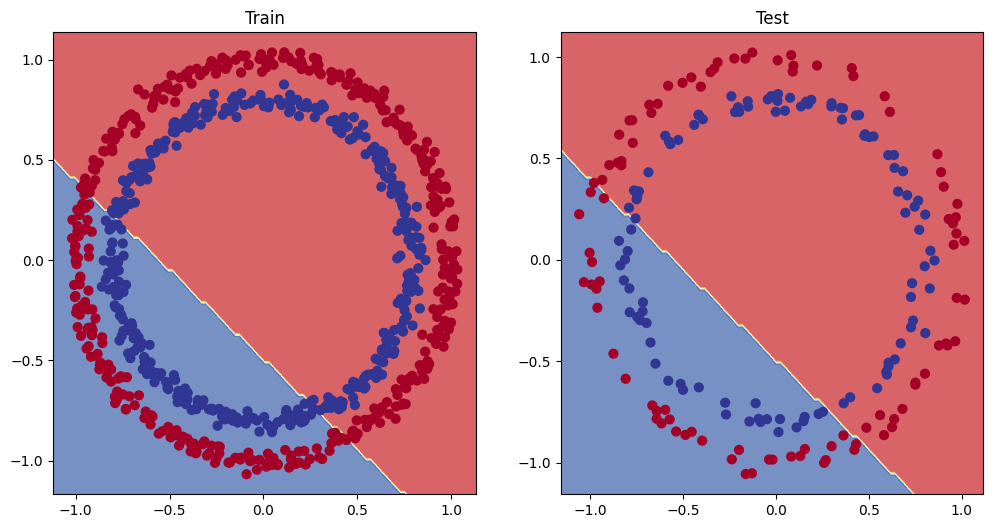

In [31]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model2, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model2, X_test, y_test)

#Preparing data to see if our model can model a straight line

In [32]:
start = 0
end = 1
step = 0.01
weight = 0.7
bias = 0.3
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X + bias

In [33]:
#train test split
split = int(0.8*len(X_regression))
X_reg_train, X_reg_test = X_regression[:split], X_regression[split:]
y_reg_train, y_reg_test = y_regression[:split], y_regression[split:]

In [34]:
len(X_reg_train), len(X_reg_test), len(y_reg_train), len(y_reg_test)

(80, 20, 80, 920)

#Adjust model2 for straight line

In [36]:
class straightmodel(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(in_features=1, out_features=10)
    self.layer2 = nn.Linear(in_features=10, out_features=10)
    self.layer3 = nn.Linear(in_features=10, out_features=1)

  def forward(self, x):
    return self.layer3(self.layer2(self.layer1(x)))

model3 = straightmodel().to(device)
X_reg_train, X_reg_test, y_reg_train, y_reg_test = X_reg_train.to(device), X_reg_test.to(device), y_reg_train.to(device), y_reg_test.to(device)

In [37]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params = model3.parameters(),lr = 0.05)